In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from nltk.tokenize import sent_tokenize
from rouge import Rouge
from sentence_transformers import SentenceTransformer

/home/jarobyte/envs/malnis/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
def show(x):
    print(x.shape)
    return x.head()

In [3]:
data = pd.read_csv("../data/clean_examples.csv", index_col = 0)
show(data)

(86, 4)


,reference_id,text,query,reference_summary
paper_id,,,,
204,1,BERT fine-tuning; multi-document summarization...,We introduce a new language representation mod...,"For instance, pre-trained sentence embedding m..."
204,643,BERT fine-tuning; multi-document summarization...,Transfer and multi-task learning have traditio...,[45] have presented a joint many-task model wi...
204,233,BERT fine-tuning; multi-document summarization...,Bidirectional Encoder Representations from Tra...,"Recently, Liu and Lapata [43] have developed a..."
855,20,"Text classification (Korde and Mahender, 2012;...",With the capability of modeling bidirectional ...,"XLNet (Yang et al., 2019) learns bidirectional..."
855,1751,"Text classification (Korde and Mahender, 2012;...","Recently, pre-trained models have achieved sta...","0 (Sun et al., 2019) proposed a continual pret..."


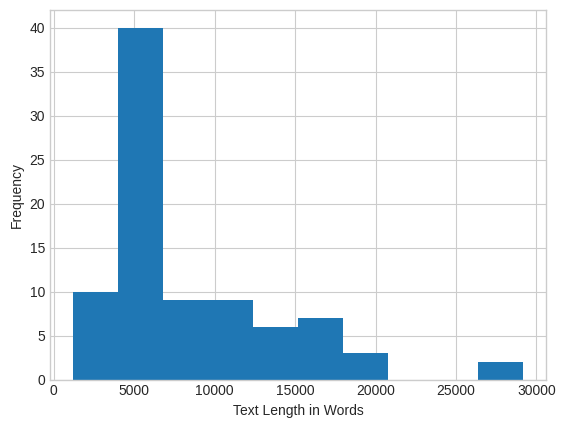

In [4]:
data.text.map(lambda x: len(x.split(" "))).plot.hist()
# t = plt.xticks()
# # print(t)
# plt.xticks(t[0], [f"{x:,.0f}" for x in t[0]])
plt.xlabel("Text Length in Words")
plt.show()

In [5]:
records = data.to_dict("records")
len(records)

86

In [6]:
records[0].keys()

dict_keys(['reference_id', 'text', 'query', 'reference_summary'])

In [7]:
results = {}

# TFIDF words

In [8]:
rouge = Rouge()
f = []
p = []
r = []
for d in tqdm(records):
    vectorizer = TfidfVectorizer()
    sentences = sent_tokenize(d["text"])
#     print(len(sentences))
    features = vectorizer.fit_transform(sentences)
#     print(features.shape)
    query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    relevant = (query_emb @ features.T).toarray().squeeze()
#     print(relevant.shape)
    retrieved = np.array(sentences)[relevant > 0.5]
    hypothesis = " ".join(retrieved)
    if len(retrieved) > 0:
        scores = rouge.get_scores(
            refs = d["reference_summary"], 
            hyps = hypothesis
        )
        s = scores[0]["rouge-1"]
#         print(s)
        f.append(s["f"])
        p.append(s["p"])
        r.append(s["r"])
    else:
        f.append(0)
        p.append(0)
        r.append(0)
#         print(None)
#     print("Query:")
#     print(d["query"])
#     print("Reference:")
#     print(d["reference"])
#     print("Hypothesis:")
#     print(hypothesis)
    
#     print()
print(f"zero rate:         {np.mean([x == 0 for x in f]):.2f}")
print(f"mean f:            {np.mean(f):.2f}")
print(f"mean precision:    {np.mean(p):.2f}")
print(f"mean recall:       {np.mean(r):.2f}")

results["tfidf_words"] = dict(
    zero_rate = np.mean([x == 0 for x in f]),
    f_measure = np.mean(f),
    precision = np.mean(p),
    recall = np.mean(r)
)

# print(results)

  0%|          | 0/86 [00:00<?, ?it/s]

zero rate:         0.70
mean f:            0.23
mean precision:    0.28
mean recall:       0.20


# TFIDF chars

In [9]:
rouge = Rouge()
f = []
p = []
r = []
for d in tqdm(records):
    vectorizer = TfidfVectorizer(
        analyzer = "char",
        ngram_range = (3, 3)
    )
    sentences = sent_tokenize(d["text"])
#     print(len(sentences))
    features = vectorizer.fit_transform(sentences)
#     print(features.shape)
    query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    relevant = (query_emb @ features.T).toarray().squeeze()
#     print(relevant.shape)
    retrieved = np.array(sentences)[relevant > 0.5]
    hypothesis = " ".join(retrieved)
    if len(retrieved) > 0:
        scores = rouge.get_scores(
            refs = d["reference_summary"], 
            hyps = hypothesis
        )
        s = scores[0]["rouge-1"]
#         print(s)
        f.append(s["f"])
        p.append(s["p"])
        r.append(s["r"])
    else:
        f.append(0)
        p.append(0)
        r.append(0)
#         print(None)
#     print("Query:")
#     print(d["query"])
#     print("Reference:")
#     print(d["reference"])
#     print("Hypothesis:")
#     print(hypothesis)
    
#     print()
print(f"zero rate:         {np.mean([x == 0 for x in f]):.2f}")
print(f"mean f:            {np.mean(f):.2f}")
print(f"mean precision:    {np.mean(p):.2f}")
print(f"mean recall:       {np.mean(r):.2f}")

results["tfidf_chars"] = dict(
    zero_rate = np.mean([x == 0 for x in f]),
    f_measure = np.mean(f),
    precision = np.mean(p),
    recall = np.mean(r)
)

# print(results)

  0%|          | 0/86 [00:00<?, ?it/s]

zero rate:         0.63
mean f:            0.26
mean precision:    0.33
mean recall:       0.24


# Sentence-BERT

In [10]:
rouge = Rouge()
f = []
p = []
r = []

In [11]:
ls ../assets

1_Pooling/                         README.md
2_Normalize/                       sentence_bert_config.json
config.json                        special_tokens_map.json
config_sentence_transformers.json  tokenizer_config.json
modules.json                       tokenizer.json
pytorch_model.bin                  vocab.txt


In [12]:
ls sbert

1_Pooling/                         README.md
2_Normalize/                       sentence_bert_config.json
config.json                        special_tokens_map.json
config_sentence_transformers.json  tokenizer_config.json
modules.json                       tokenizer.json
pytorch_model.bin                  vocab.txt


In [13]:
model = SentenceTransformer(
    "sbert"
#     'all-MiniLM-L6-v2', 
#     cache_folder = "../assets"
#     "../cache/huggingface/transformers/"
#     cache_folder = "../cache/huggingface/transformers"
)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [14]:
for d in tqdm(records):
#     vectorizer = TfidfVectorizer()
    sentences = sent_tokenize(d["text"])
#     print(len(sentences))
#     features = vectorizer.fit_transform(sentences)
#     print(features.shape)
#     query_emb = vectorizer.transform([d["query"]])
#     print(query_emb.shape)
    features = model.encode(sentences)
    query_emb = model.encode([d["query"]])
    relevant = (query_emb @ features.T).squeeze()
#     print(relevant.shape)
    retrieved = np.array(sentences)[relevant > 0.5]
    hypothesis = " ".join(retrieved)
    if len(retrieved) > 0:
        scores = rouge.get_scores(
            refs = d["reference_summary"], 
            hyps = hypothesis
        )
        s = scores[0]["rouge-1"]
#         print(s)
        f.append(s["f"])
        p.append(s["p"])
        r.append(s["r"])
    else:
        f.append(0)
        p.append(0)
        r.append(0)
#         print(None)
#     print("Query:")
#     print(d["query"])
#     print("Reference:")
#     print(d["reference"])
#     print("Hypothesis:")
#     print(hypothesis)
    
#     print()
print(f"zero rate:         {np.mean([x == 0 for x in f]):.2f}")
print(f"mean f:            {np.mean(f):.2f}")
print(f"mean precision:    {np.mean(p):.2f}")
print(f"mean recall:       {np.mean(r):.2f}")

results["sentence_bert"] = dict(
    zero_rate = np.mean([x == 0 for x in f]),
    f_measure = np.mean(f),
    precision = np.mean(p),
    recall = np.mean(r)
)

# print(results)

  0%|          | 0/86 [00:00<?, ?it/s]

zero rate:         0.00
mean f:            0.32
mean precision:    0.23
mean recall:       0.80


In [15]:
pd.DataFrame(results).T.round(2)

,zero_rate,f_measure,precision,recall
tfidf_words,0.70,0.23,0.28,0.20
tfidf_chars,0.63,0.26,0.33,0.24
sentence_bert,0.00,0.32,0.23,0.80
